This notebook trains a feed‑forward Neural Network on the fully scaled and encoded dataset, tuning hidden layer sizes, activation functions, and regularization to model complex non‑linear relationships in attrition risk. Despite several rounds of hyperparameter and model‑complexity tuning, training remained unstable and the network often failed to learn robustly, which is attributed to the limited dataset size and the model’s capacity.

In the recall‑optimized evaluation on the test set, the neural network nevertheless achieves recall ≈70.2%, precision ≈32.0%, F1 ≈0.44, and accuracy ≈0.71, with 14 missed departures and 70 false alarms. Its performance is close to Logistic Regression (slightly lower recall but similar precision and F1), making it a strong but less interpretable and less stable alternative in the final comparison.

In [ ]:
#!pip install imbalanced-learn



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
# ============================================
# 1. IMPORTS
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings

warnings.filterwarnings('ignore')

# Add parent directory to path for preprocessing import
sys.path.append('scripts')
from preprocessing import preprocess

# Keras/TensorFlow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sklearn metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight

# SMOTE for oversampling
from imblearn.over_sampling import SMOTE

import joblib
import json



In [57]:
# ============================================
# RUN PREPROCESSING
# ============================================

X_train, X_val, X_test, y_train, y_val, y_test = preprocess(
    data_path='data/raw/HR_Attrition_Dataset.csv'
)

# Display basic info
print("=" * 60)
print("PREPROCESSING RESULTS")
print("=" * 60)
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFeatures: {list(X_train.columns)}")
print(f"\nClass distribution - Training:")
print(y_train.value_counts(normalize=True).round(3))
print("=" * 60)


Kept 14 columns from original dataset

Final feature shapes:
  X_train: (882, 18)
  X_val: (294, 18)
  X_test: (294, 18)

Total features: 18
PREPROCESSING RESULTS
Training set: 882 samples, 18 features
Validation set: 294 samples
Test set: 294 samples

Features: ['JobSatisfaction', 'JobInvolvement', 'EnvironmentSatisfaction', 'JobRole_Research Director', 'JobRole_Sales Representative', 'BusinessTravel_Travel_Frequently', 'WorkLifeBalance', 'Department_Research & Development', 'YearsAtCompanyLog', 'TotalWorkingYearsLog', 'MaritalStatus_Single', 'OverTime_Yes', 'JobRole_Laboratory Technician', 'JobRole_Manufacturing Director', 'MaritalStatus_Married', 'JobRole_Manager', 'NumCompaniesWorked', 'JobRole_Healthcare Representative']

Class distribution - Training:
Attrition
0    0.838
1    0.162
Name: proportion, dtype: float64


In [58]:
# ============================================
# PREPARE DATA & CALCULATE CLASS WEIGHTS
# ============================================

# Calculate class imbalance
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
imbalance_ratio = n_negative / n_positive

print("\n" + "=" * 60)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 60)
print(f"Class 0 (Stay): {n_negative}")
print(f"Class 1 (Leave): {n_positive}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

# Convert to numpy arrays for Keras
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.astype(np.float32)
y_val_np = y_val.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

# Define class weights for Keras
class_weights_dict = {
    0: 1.0,
    1: 5.0  
}

print(f"\nClass weights for training: {class_weights_dict}")
print("=" * 60)



CLASS IMBALANCE ANALYSIS
Class 0 (Stay): 739
Class 1 (Leave): 143
Imbalance ratio: 5.17

Class weights for training: {0: 1.0, 1: 5.0}


In [ ]:
# ============================================
# BUILD NEURAL NETWORK WITH FOCAL LOSS
# ============================================

def focal_loss(gamma=2.0, alpha=0.75): 
    """Focal loss for imbalanced classification"""
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_loss = -alpha_t * tf.pow((1 - p_t), gamma) * tf.math.log(p_t)
        
        return tf.reduce_mean(focal_loss)
    
    return focal_loss_fixed


def build_model_final(input_dim, learning_rate=0.0005):
    """
    FINAL OPTIMAL MODEL
    - 3 hidden layers (128->64->32)
    - Original dropout rates (0.3, 0.3, 0.2)
    - Focal loss with gamma=2.0 (original)
    - NO gradient clipping (not needed)
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        
        layers.Dense(128, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005), 
        loss=focal_loss(gamma=2.0, alpha=0.75), 
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    
    return model




# Build model
print("\n" + "=" * 60)
print("BUILDING OPTIMAL MODEL")
print("=" * 60)
model = build_model_final(input_dim=X_train_np.shape[1])
model.summary()
print("=" * 60)



BUILDING OPTIMAL MODEL


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,185 (51.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# ============================================
# DEFINE CALLBACKS (REVISED)
# ============================================


early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=7, 
    mode='max',
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=4,
    mode='max',
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

print("\n" + "=" * 60)
print("CALLBACKS CONFIGURED")
print("=" * 60)
print(f"Early Stopping: monitor='val_auc', patience=10")
print(f"Reduce LR: monitor='val_auc', patience=5, factor=0.5")
print("=" * 60)



CALLBACKS CONFIGURED
Early Stopping: monitor='val_auc', patience=10
Reduce LR: monitor='val_auc', patience=5, factor=0.5


In [ ]:
# ============================================
# TRAIN NEURAL NETWORK
# ============================================

print("\n" + "=" * 60)
print("TRAINING WITH OPTIMAL CONFIGURATION")
print("=" * 60)
print("Key settings:")
print("  - Architecture: 128->64->32")
print("  - Learning rate: 0.0005")
print("  - Batch size: 64")
print("  - Class weights: {0: 1.0, 1: 5.0}")
print("  - Dropout: 0.3, 0.3, 0.2")
print("  - Focal loss gamma: 2.0")
print("  - Early stopping patience: 7")
print("=" * 60 + "\n")

history = model.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=100,
    batch_size=64, 
    class_weight={0: 1.0, 1: 5.0},
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 60)
print("TRAINING COMPLETED")
print("=" * 60)


TRAINING WITH OPTIMAL CONFIGURATION
Key settings:
  - Architecture: 128->64->32
  - Learning rate: 0.0005
  - Batch size: 64
  - Class weights: {0: 1.0, 1: 5.0}
  - Dropout: 0.3, 0.3, 0.2
  - Focal loss gamma: 2.0
  - Early stopping patience: 7

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4301 - auc: 0.4960 - loss: 0.4409 - precision: 0.1635 - recall: 0.6461 - val_accuracy: 0.3878 - val_auc: 0.5742 - val_loss: 0.2165 - val_precision: 0.1756 - val_recall: 0.7660 - learning_rate: 5.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5032 - auc: 0.5690 - loss: 0.3488 - precision: 0.1866 - recall: 0.6573 - val_accuracy: 0.6122 - val_auc: 0.6772 - val_loss: 0.2108 - val_precision: 0.2276 - val_recall: 0.5957 - learning_rate: 5.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5786 - auc: 0.6622 - loss: 0.3233 - precision: 0.2291 - recall: 0.6679 - val_accuracy: 0.7449 - val_auc: 0.7223 - val_loss: 0.2074 - val_precision: 0

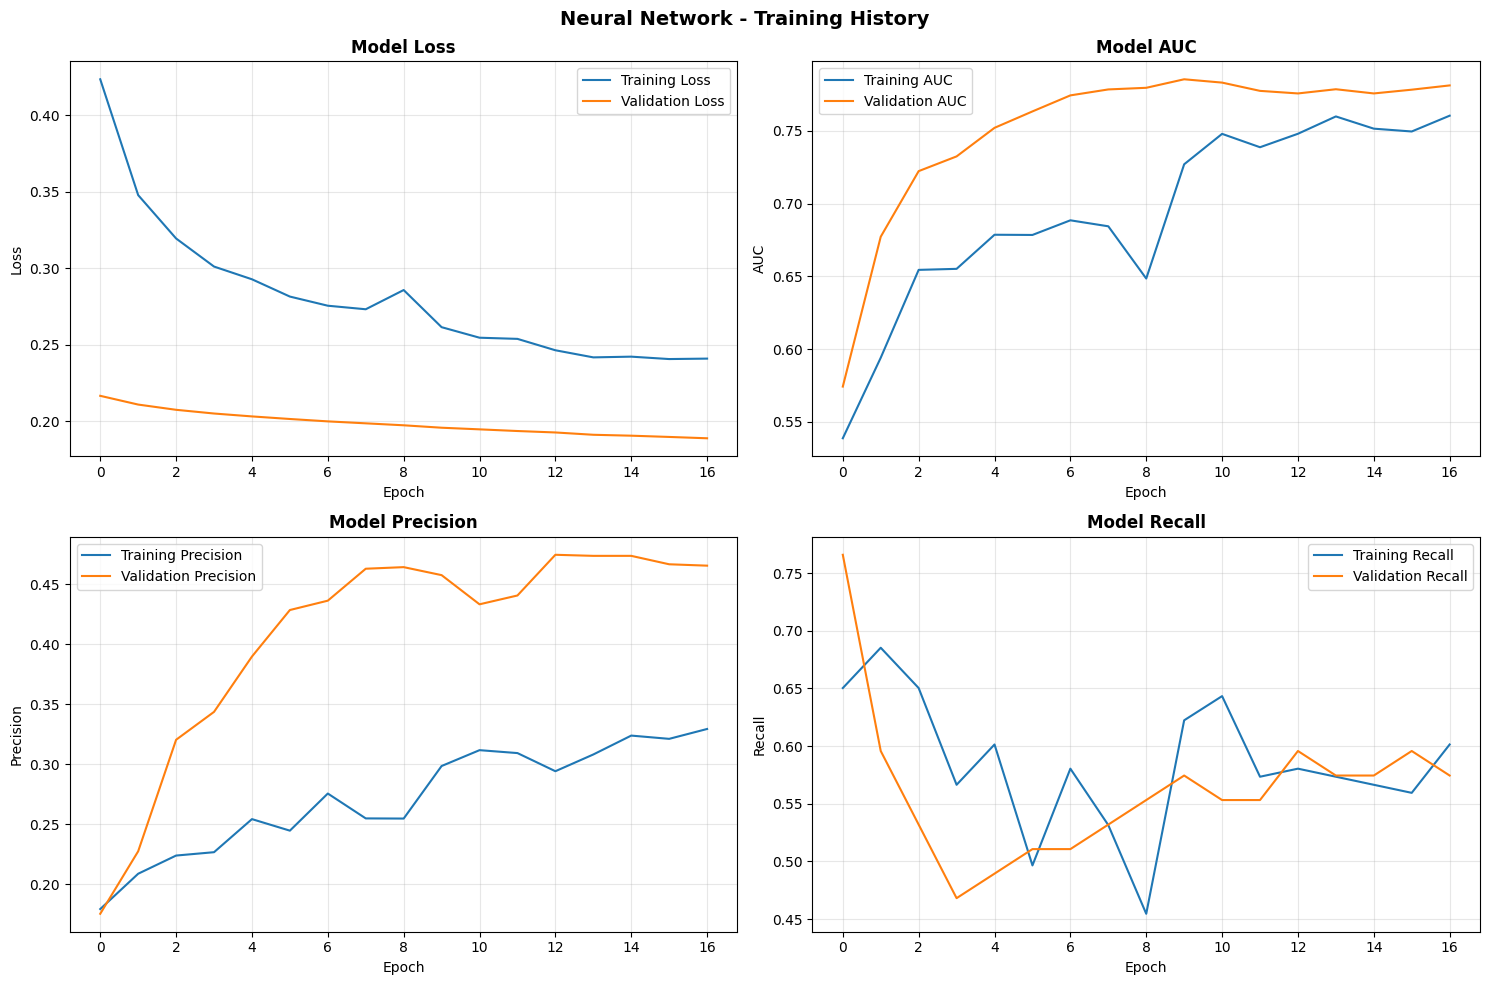

In [62]:
# ============================================
# PLOT TRAINING HISTORY
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot AUC
axes[0, 1].plot(history.history['auc'], label='Training AUC')
axes[0, 1].plot(history.history['val_auc'], label='Validation AUC')
axes[0, 1].set_title('Model AUC', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Neural Network - Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [63]:
# ============================================
# 9. THRESHOLD OPTIMIZATION - DUAL STRATEGY
# ============================================
# 1. F1-Optimized: Best balance between precision and recall
# 2. Recall-Optimized: Minimize surprise departures
# ============================================

# Get predicted probabilities on validation set
y_val_proba = model.predict(X_val_np).ravel()

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val_np, y_val_proba)

# ---- F1-OPTIMIZED THRESHOLD ----
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
best_f1_idx = np.argmax(f1_scores)
f1_optimal_threshold = thresholds[best_f1_idx]
f1_achieved_recall = recalls[best_f1_idx]
f1_achieved_precision = precisions[best_f1_idx]
f1_achieved_f1 = f1_scores[best_f1_idx]

# ---- RECALL-OPTIMIZED THRESHOLD ----
TARGET_RECALL = 0.70  # Catch at least 70% of leavers

valid_indices = np.where(recalls[:-1] >= TARGET_RECALL)[0]

if len(valid_indices) > 0:
    best_idx = valid_indices[np.argmax(precisions[:-1][valid_indices])]
    recall_optimal_threshold = thresholds[best_idx]
    recall_achieved_recall = recalls[best_idx]
    recall_achieved_precision = precisions[best_idx]
else:
    recall_optimal_threshold = thresholds[0]
    recall_achieved_recall = recalls[0]
    recall_achieved_precision = precisions[0]
    print(f"WARNING: Target recall {TARGET_RECALL:.0%} not achievable. Using lowest threshold.")

print("=" * 60)
print("THRESHOLD OPTIMIZATION RESULTS")
print("=" * 60)
print(f"\n{'F1-OPTIMIZED THRESHOLD':-<60}")
print(f"Threshold: {f1_optimal_threshold:.3f}")
print(f"Precision: {f1_achieved_precision:.2%}")
print(f"Recall: {f1_achieved_recall:.2%}")
print(f"F1 Score: {f1_achieved_f1:.3f}")

print(f"\n{'RECALL-OPTIMIZED THRESHOLD':-<60}")
print(f"Target Recall: {TARGET_RECALL:.0%}")
print(f"Threshold: {recall_optimal_threshold:.3f}")
print(f"Precision: {recall_achieved_precision:.2%}")
print(f"Recall: {recall_achieved_recall:.2%}")
print("=" * 60)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
THRESHOLD OPTIMIZATION RESULTS

F1-OPTIMIZED THRESHOLD--------------------------------------
Threshold: 0.497
Precision: 47.69%
Recall: 65.96%
F1 Score: 0.554

RECALL-OPTIMIZED THRESHOLD----------------------------------
Target Recall: 70%
Threshold: 0.471
Precision: 33.00%
Recall: 70.21%


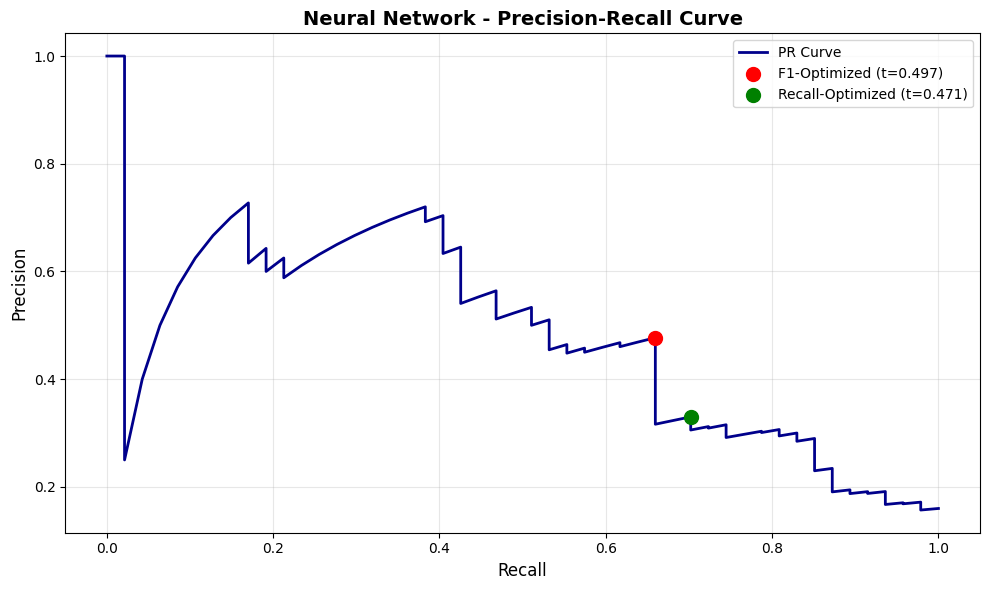

In [64]:
# ============================================
# 10. VISUALIZE PRECISION-RECALL TRADEOFF
# ============================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot Precision-Recall curve
ax.plot(recalls, precisions, label='PR Curve', linewidth=2, color='darkblue')
ax.scatter([f1_achieved_recall], [f1_achieved_precision], 
           color='red', s=100, zorder=5, label=f'F1-Optimized (t={f1_optimal_threshold:.3f})')
ax.scatter([recall_achieved_recall], [recall_achieved_precision], 
           color='green', s=100, zorder=5, label=f'Recall-Optimized (t={recall_optimal_threshold:.3f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Neural Network - Precision-Recall Curve', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [65]:
# ============================================
# 11. EVALUATE ON TEST SET - ALL THRESHOLDS
# ============================================

# Get test probabilities
y_test_proba = model.predict(X_test_np).ravel()

# Default threshold (0.5)
y_test_pred_default = (y_test_proba >= 0.5).astype(int)

# F1-optimized threshold
y_test_pred_f1 = (y_test_proba >= f1_optimal_threshold).astype(int)

# Recall-optimized threshold
y_test_pred_recall = (y_test_proba >= recall_optimal_threshold).astype(int)

# Calculate AUC
auc_score = roc_auc_score(y_test_np, y_test_proba)

print("=" * 60)
print("TEST SET EVALUATION - NEURAL NETWORK")
print("=" * 60)
print(f"\nAUC Score: {auc_score:.3f}\n")

# Function to print metrics
def print_metrics(y_true, y_pred, threshold_name):
    print(f"\n{'='*60}")
    print(f"{threshold_name}")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=['Stay', 'Leave']))
    print(f"Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    # Calculate missed departures
    cm = confusion_matrix(y_true, y_pred)
    false_negatives = cm[1, 0]
    print(f"\nMissed Departures (False Negatives): {false_negatives}")

# Evaluate all thresholds
print_metrics(y_test_np, y_test_pred_default, "DEFAULT THRESHOLD (0.50)")
print_metrics(y_test_np, y_test_pred_f1, f"F1-OPTIMIZED THRESHOLD ({f1_optimal_threshold:.3f})")
print_metrics(y_test_np, y_test_pred_recall, f"RECALL-OPTIMIZED THRESHOLD ({recall_optimal_threshold:.3f})")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
TEST SET EVALUATION - NEURAL NETWORK

AUC Score: 0.733


DEFAULT THRESHOLD (0.50)
              precision    recall  f1-score   support

        Stay       0.90      0.85      0.87       247
       Leave       0.39      0.51      0.44        47

    accuracy                           0.79       294
   macro avg       0.64      0.68      0.66       294
weighted avg       0.82      0.79      0.80       294

Confusion Matrix:
[[209  38]
 [ 23  24]]

Missed Departures (False Negatives): 23

F1-OPTIMIZED THRESHOLD (0.497)
              precision    recall  f1-score   support

        Stay       0.90      0.84      0.87       247
       Leave       0.38      0.51      0.44        47

    accuracy                           0.79       294
   macro avg       0.64      0.68      0.65       294
weighted avg       0.82      0.79      0.80       294

Confusion Matrix:
[[208  39]
 [ 23  24]]

Missed Departures (False Negatives): 23

RECALL-OPTIMIZED THRESHOLD 

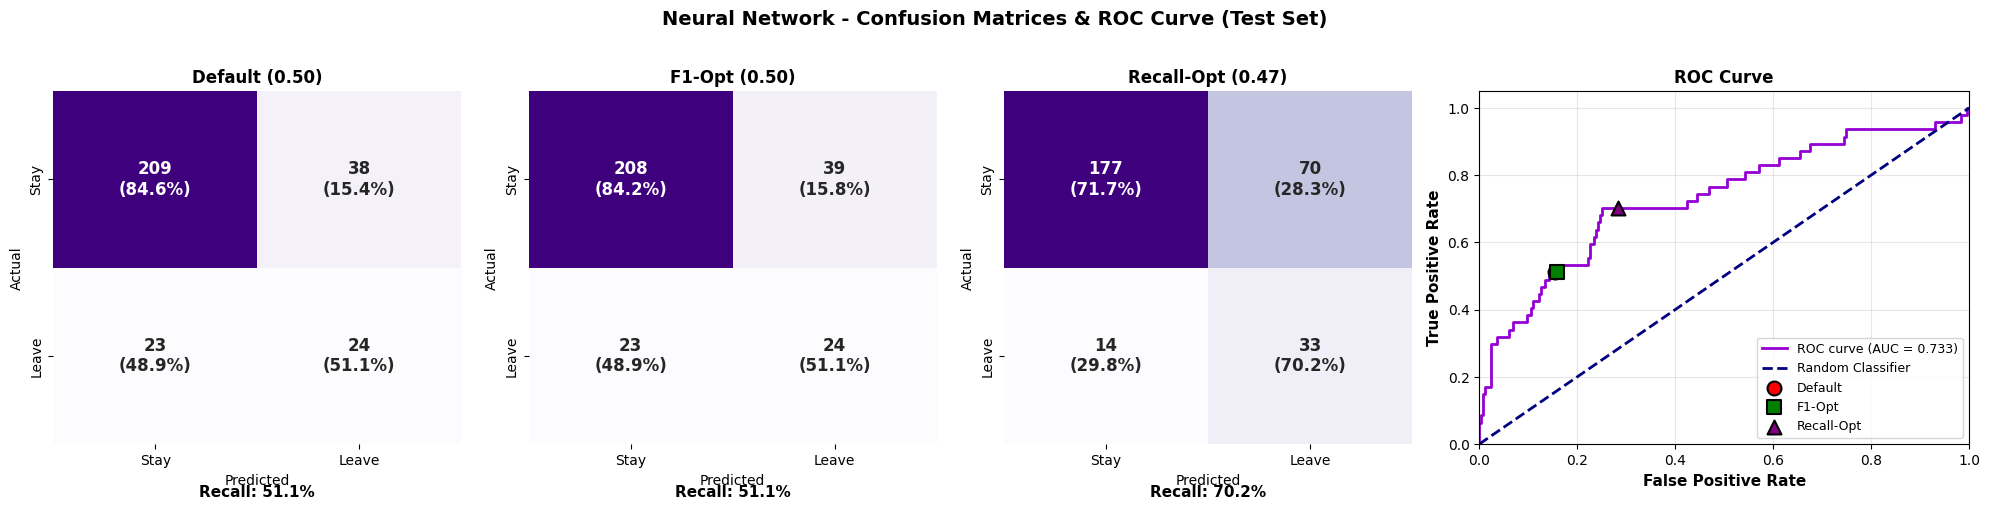

In [66]:
# ============================================
# 12. VISUALIZE CONFUSION MATRICES WITH PERCENTAGES + ROC CURVE
# ============================================

fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1.2])

# First 3 subplots for confusion matrices
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

thresholds_data = [
    ("Default (0.50)", y_test_pred_default),
    (f"F1-Opt ({f1_optimal_threshold:.2f})", y_test_pred_f1),
    (f"Recall-Opt ({recall_optimal_threshold:.2f})", y_test_pred_recall)
]

for idx, (title, y_pred) in enumerate(thresholds_data):
    cm = confusion_matrix(y_test_np, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with counts and percentages
    annot = np.array([[f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)' 
                       for j in range(cm.shape[1])] 
                      for i in range(cm.shape[0])])
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Purples',
                xticklabels=['Stay', 'Leave'],
                yticklabels=['Stay', 'Leave'],
                cbar=False, ax=axes[idx],
                annot_kws={'size': 12, 'weight': 'bold'})
    
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    
    # Add recall at bottom
    recall = recall_score(y_test_np, y_pred)
    axes[idx].text(0.5, -0.15, f'Recall: {recall:.1%}', 
                   transform=axes[idx].transAxes,
                   fontsize=11, fontweight='bold',
                   horizontalalignment='center')

# Fourth subplot for ROC curve
ax_roc = fig.add_subplot(gs[0, 3])

# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test_np, y_test_proba)

# Plot ROC curve
ax_roc.plot(fpr, tpr, color='darkviolet', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

# Mark the threshold points
for threshold_name, y_pred, color, marker in [
    ("Default", y_test_pred_default, 'red', 'o'),
    ("F1-Opt", y_test_pred_f1, 'green', 's'),
    ("Recall-Opt", y_test_pred_recall, 'purple', '^')
]:
    cm = confusion_matrix(y_test_np, y_pred)
    fpr_point = cm[0, 1] / (cm[0, 0] + cm[0, 1])  # FP / (TN + FP)
    tpr_point = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # TP / (FN + TP)
    ax_roc.scatter([fpr_point], [tpr_point], s=100, c=color, marker=marker, 
                   edgecolors='black', linewidths=1.5, label=threshold_name, zorder=5)

ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax_roc.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax_roc.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax_roc.legend(loc='lower right', fontsize=9)
ax_roc.grid(alpha=0.3)

plt.suptitle('Neural Network - Confusion Matrices & ROC Curve (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [67]:
# ============================================
# 13. SAVE MODEL AND METADATA
# ============================================

# Save Keras model
model_path = 'models/nn_attrition_model.h5'
model.save(model_path)

# Save metadata
metadata = {
    'model_type': 'Neural Network (Keras)',
    'architecture': {
        'layers': ['Dense(128, relu)', 'Dropout(0.3)', 'Dense(64, relu)', 
                   'Dropout(0.3)', 'Dense(32, relu)', 'Dropout(0.2)', 'Dense(1, sigmoid)'],
        'optimizer': 'Adam',
        'loss': 'binary_crossentropy'
    },
    'training': {
        'epochs_trained': len(history.history['loss']),
        'best_val_auc': float(max(history.history['val_auc'])),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1])
    },
    'test_performance': {
        'auc_score': float(auc_score)
    },
    'thresholds': {
        'default': 0.5,
        'f1_optimized': float(f1_optimal_threshold),
        'recall_optimized': float(recall_optimal_threshold)
    },
    'class_weights': class_weights_dict
}

metadata_path = 'models/nn_model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nModel saved to: {model_path}")
print(f"Metadata saved to: {metadata_path}")



Model saved to: models/nn_attrition_model.h5
Metadata saved to: models/nn_model_metadata.json
